
- Costruire un dataset di grafi di spin glass di piccola taglia (# basso di nodi) e studiare come l'apprendimento dell'energia da parte della GNN cambia al variare della connettività del grafo. Ad esempio fissando a 10 il numero di nodi, il numero di edges può essere cambiato da 9 (open spin glass chain) a 45 (fully connected spin glass) , magari provando 9, 15, 25, 45. Si costruiscono 4 dataset e si allena la stessa GNN separatamente su questi dataset in modo supervised per fare poi il confronto. (Livello medio)

In [13]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

import torch.nn.functional as F
from torch_geometric.profile import get_model_size

from torch.nn import Linear
from torch_geometric.nn import global_max_pool, GraphConv
from torch_geometric.loader import DataLoader

import os 


In [14]:
# set standard dimensions for the plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14


In [15]:
def initialize_graph(L, periodic=True, n_dimensions=2):
    """
    Initialize a graph with L nodes
    """
    G = nx.Graph()
    for i in range(L):
        G.add_node(i, spin = np.random.choice([-1, 1]))
    
    for i in range(L):
        if periodic:
            for j in range(i+1, i+n_dimensions+1):
                G.add_edge(i, j % L, weight = np.random.rand()*2 -1 )
        else:
            for j in range(i+1, i+n_dimensions+1):
                if j < L:
                    G.add_edge(i, j, weight = np.random.rand()*2 -1 )
    return G
     

def plot_graph(G, pos=None):
    """
    Plot the graph with nodes colored according to their spin.
    """
    if pos is None:
        pos = nx.circular_layout(G)
    colors = ['blue' if G.nodes[i]["spin"] == 1 else 'red' for i in range(len(G.nodes) )]
    fig = plt.figure()
    nx.draw(G, pos = pos, node_color=colors, with_labels=True)
    plt.show(fig)    
    return fig
    

def calculate_energy(G, h=0 ):
    """
    Calculate the energy of the graph
    """
    E = 0
    E_h = 0
    for i, j in G.edges:
        E += G[i][j]["weight"] * G.nodes[i]["spin"] * G.nodes[j]["spin"]

    if h != 0:  # exclude the case of h = 0 to avoid floating point errors
        E_h = h * np.sum([G.nodes[i]["spin"] for i in G.nodes]) 


    return -E/2 - E_h  # divide by 2 to avoid double counting

# create a dataset with the energy as label
def create_dataset(n_nodes=10, h=0, periodic= True, n_dimensions=1, n_samples=1000, return_MLP=False, save = False, path = None):
    dataset = []
    graphs = []
    MLP_list= []

    for i in range(n_samples):
        G = initialize_graph(n_nodes, periodic=periodic, n_dimensions=n_dimensions)
        X = torch.tensor([G.nodes[i]["spin"] for i in G.nodes]).float().view(-1, 1)
        graphs.append(G)
        dataset.append(
            Data(x = X, 
                edge_index = torch.tensor(np.array(G.edges).T, dtype=torch.long),
                edge_weight = torch.tensor([G[i][j]["weight"] for i, j in G.edges], dtype=torch.float),
                y = torch.tensor([calculate_energy(G, h)], dtype=torch.float) ) )  

        if save:
            if path is None:
                path = os.getcwd()
            if not os.path.exists(path):
                os.makedirs(path)
            torch.save(dataset, os.path.join(path, f"dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
            torch.save(graphs, os.path.join(path, f"graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))

    if return_MLP:

        # extract the adjacency matrix
        A = nx.adjacency_matrix(G).todense()
        # concatenate the adjacency matrix to the node features to use it for the MLP in the other task
        M = torch.cat([X, torch.tensor(A).float()], dim=1)
        MLP_list.append(M)

        if save:
            torch.save(MLP_list, os.path.join(path, f"MLP_list_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt"))
        return dataset, graphs, MLP_list
    else:
        return dataset, graphs

In [16]:
# GNN model

class GNN(torch.nn.Module):
    def __init__(self,hidden_channels_1=16, hidden_channels_2=16, hidden_channels_3=16,hidden_channels_4 = 16, hidden_linear=16,
                 lr = 1e-5, weight_decay=1e-3, dropout=0.5, num_node_features=1, num_classes=1):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(num_node_features,hidden_channels_1)
        self.conv2 = GraphConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GraphConv(hidden_channels_2, hidden_channels_3)
        self.conv4 = GraphConv(hidden_channels_3, hidden_channels_4)

        self.pool = global_max_pool

        self.linear1 = Linear(hidden_channels_4, hidden_linear)
        self.linear2 = Linear(hidden_linear, num_classes)

        

        self.dropout = torch.nn.Dropout(dropout)

        # we should consider also batch normalization in case of overfitting



        # Optimizer:
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        # Loss function:
        self.criterion = torch.nn.MSELoss()

        
    
    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv2(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv4(x, edge_index, edge_weight))

        x = self.pool(x, data.batch) # [n_nodes*n_graph_of_the_batch, n_features] -> [n_graph_of_the_batch, n_features]

        #x = torch.flatten(x) # not needed since we are using global_max_pool
        #print(x.shape)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear1(x))
        out = self.linear2(x)

        return out
    

    
    def train_step(self, data):
        # Reset gradients
        self.optimizer.zero_grad()
        # Passing the node features and the connection info
        prediction = self.forward(data)
        # reshape the prediction to match the shape of the target
        prediction = prediction.view(data.y.shape)
        # Calculating the loss and gradients
        loss = self.criterion(prediction, data.y)
        #print("prediction:",prediction.shape)
        #print("data.y:",data.y.shape)
        loss.backward()
        # Update using the gradients
        self.optimizer.step()
        
        return loss.item()
    

In [17]:
def plot_loss( train_losses, test_losses):
    fig = plt.figure()
    epoch = range(1, len(train_losses)+1)
    plt.plot(epoch, train_losses, label='Training Loss')
    plt.plot(epoch, test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    return fig


def train_model(model, train_loader, test_loader, num_epochs, patience = 5, model_name='best_model', verbose = True, device= None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # parameters for patience
    best_loss = np.inf
    patience_counter = 0


    epochs = range(1, num_epochs+1)
    train_losses, test_losses = [], []
    
    print('Training ...')

    for epoch in epochs:
        loss_per_epoch = []
        test_loss_per_epoch = []

        for i, mini_batch in enumerate(train_loader):
            mini_batch.to(device)
            train_loss = model.train_step(mini_batch)
            loss_per_epoch.append(train_loss)

        train_losses.append(sum(loss_per_epoch)/len(loss_per_epoch))


        with torch.no_grad():
            """Evaluate the model on test set"""
            for i, mini_batch in enumerate(test_loader):
                mini_batch.to(device)
                prediction = model.forward(mini_batch)
                prediction.to('cpu')
                test_loss = model.criterion(prediction, mini_batch.y).item()
                test_loss_per_epoch.append(test_loss)
            test_losses.append(sum(test_loss_per_epoch)/len(test_loss_per_epoch))
            
            if test_losses[-1] < best_loss:
                best_loss = test_losses[-1]
                torch.save(model.state_dict(), model_name + '/model.pth')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print(f"Early stopping at epoch {epoch}")
                    break
        if verbose:
            print(f"Ep {epoch} \t| Loss {round(train_losses[-1], 5)} \t| Test Loss {round(test_losses[-1], 5)}")


    return  train_losses, test_losses

In [18]:
# set the model name based on the values
def set_model_name(n_nodes, n_dimensions, h, periodic,n_samples, hidden_channels_1,
                    hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear,
                    lr, weight_decay, dropout, epochs):
    return f"model_{n_nodes}_{n_dimensions}_{h}_{periodic}_{n_samples}_{hidden_channels_1}_{hidden_channels_2}_{hidden_channels_3}_{hidden_channels_4}_{hidden_linear}_{lr}_{weight_decay}_{dropout}_{epochs}"


# translate the model name into values
def print_values_from_model_name(model_name, print_values=True, return_dict = False): 
    values = model_name.split('_')
    # create a dictionary to store the values 
    dict = {"n_nodes": values[1], "n_dimensions": values[2], "h": values[3], "periodic": values[4], "n_samples": values[5],
            "hidden_channels_1": values[6], "hidden_channels_2": values[7], "hidden_channels_3": values[8], "hidden_channels_4": values[9], "hidden_linear": values[10],
            "lr": values[11], "weight_decay": values[12], "dropout": values[13], "epochs": values[14]}
    if print_values:
        for key, value in dict.items():
            print(f"{key}: {value}")
    if return_dict:
        return dict
    
    

def test_trained_model(model_name, test_loader, device = None):

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    values = print_values_from_model_name(model_name, print_values=False, return_dict=True)

    trained_model = GNN(hidden_channels_1= int(values["hidden_channels_1"]),
                hidden_channels_2= int(values["hidden_channels_2"]),
                hidden_channels_3= int(values["hidden_channels_3"]),
                hidden_channels_4= int(values["hidden_channels_4"]),
                hidden_linear= int(values["hidden_linear"]),
                lr= float(values["lr"]), weight_decay= float(values["weight_decay"]), dropout= float(values["dropout"]))
    
    trained_model.load_state_dict(torch.load(model_name + '/model.pth'))
    trained_model.to(device)

    fig = plt.figure()
    with torch.no_grad():
        predictions = []
        true_values = []
        for i, mini_batch in enumerate(test_loader):
            mini_batch.to(device)
            prediction = trained_model.forward(mini_batch)
            predictions.append(prediction.item())
            true_values.append(mini_batch.y.item())
        
        # save the mean squared error
        mse = np.mean((np.array(predictions) - np.array(true_values))**2)
       
        plt.scatter(true_values, predictions)
        plt.plot(true_values, true_values, color='red')
        plt.xlabel('True energy')
        plt.ylabel('Predicted energy')
        plt.title('Predicted vs True energy')
    
        at = AnchoredText(f"MSE: {np.round(mse,2)}", frameon=True, loc='upper left')
        plt.gca().add_artist(at)

        # plot a box similar to the legend to show the MSE
        plt.grid(True)
        plt.show()
    
    

    return fig, mse


In [19]:
# set the device and a random seed
torch.manual_seed(1022000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Device: ', device)

# set the palette
palette = sns.color_palette("coolwarm", as_cmap=True)

Device:  cpu


In [20]:
# set standard parameters for the model

# parameters for the dataset
n_nodes = 10
h = 0
n_samples = 5000

# parameters for the model
num_epochs = 30
batch_size = 1
lr = 5e-4
weight_decay = 1e-4
dropout = 0.4
patience = 15

# parameters for the layers
hidden_channels_1 = 16
hidden_channels_2 = 32
hidden_channels_3 = 32
hidden_channels_4 = 64
hidden_linear = 32

In [21]:
# create the model
starting_model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

# Model size and number of parameters of the model:
print(44 * '-')
print("Model:")
print("Model size (bytes):\t\t  ", get_model_size(starting_model))
print("Number of parameters:\t\t  ", sum(p.numel() for p in starting_model.parameters()))
print(44 * '-')


--------------------------------------------
Model:
Model size (bytes):		   43862
Number of parameters:		   9457
--------------------------------------------


In [22]:
# prepare lists to store the results
list_dimensions = [1,2,3,4,5]
list_periodic = [False, True]
list_datasets = []
list_graphs = []
list_n_connections = []
list_model_names = []
list_train_losses = []
list_test_losses = []
list_fig_losses = []
list_fig_tests = []
list_mse = []

In [23]:
# create and save the datasets
create = False
save = True


# MLP_list is really time consuming,
# it's more clever to save only the datasets and build the graphs and MLP_list again if needed (task 2)


try:
    os.mkdir("datasets")
except:
    pass

if create:
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            print(f"creating datasets with: n_dimensions: {n_dimensions}, periodic: {periodic}")
            
            dataset, graphs = create_dataset(n_nodes=n_nodes, h=h, periodic=periodic, n_dimensions=n_dimensions, n_samples=n_samples, save=False)
            list_datasets.append(dataset)
            list_graphs.append(graphs)

            if save:
                torch.save(dataset, f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
                torch.save(graphs, f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
else:
    print("loading datasets")
    for n_dimensions in list_dimensions:
        for periodic in list_periodic:
            dataset = torch.load(f"datasets/dataset_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            graphs = torch.load(f"datasets/graphs_{n_nodes}_{h}_{periodic}_{n_dimensions}_{n_samples}.pt")
            list_datasets.append(dataset)
            list_graphs.append(graphs)
print("Done!")

loading datasets
Done!


n_dimensions: 1, periodic: False, number of connections: 9


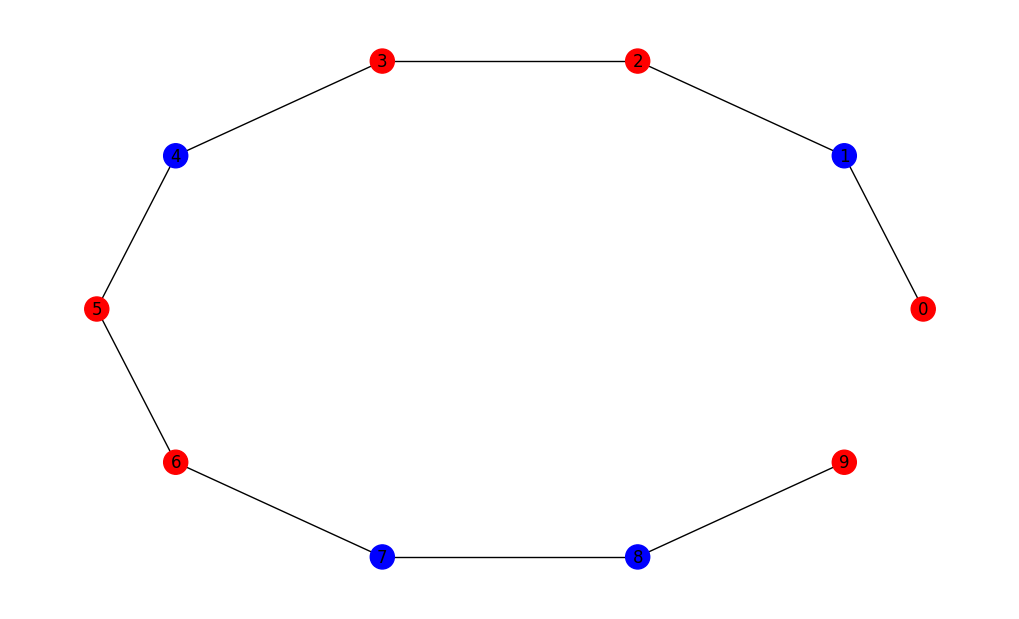

Training ...


/home/claudio/anaconda3/envs/pytorch/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ep 1 	| Loss 0.30065 	| Test Loss 0.17216
Ep 2 	| Loss 0.16769 	| Test Loss 0.15104
Ep 3 	| Loss 0.14807 	| Test Loss 0.14301
Ep 4 	| Loss 0.13478 	| Test Loss 0.12705
Ep 5 	| Loss 0.13083 	| Test Loss 0.12351
Ep 6 	| Loss 0.11993 	| Test Loss 0.11382
Ep 7 	| Loss 0.11312 	| Test Loss 0.11157
Ep 8 	| Loss 0.11019 	| Test Loss 0.11108
Ep 9 	| Loss 0.10977 	| Test Loss 0.11112
Ep 10 	| Loss 0.10532 	| Test Loss 0.10825
Ep 11 	| Loss 0.10274 	| Test Loss 0.1004
Ep 12 	| Loss 0.10049 	| Test Loss 0.10489
Ep 13 	| Loss 0.09644 	| Test Loss 0.10829
Ep 14 	| Loss 0.0994 	| Test Loss 0.10013
Ep 15 	| Loss 0.09708 	| Test Loss 0.10098
Ep 16 	| Loss 0.09571 	| Test Loss 0.10124
Ep 17 	| Loss 0.09346 	| Test Loss 0.09873
Ep 18 	| Loss 0.0953 	| Test Loss 0.10389
Ep 19 	| Loss 0.09099 	| Test Loss 0.10064
Ep 20 	| Loss 0.09059 	| Test Loss 0.10121
Ep 21 	| Loss 0.09076 	| Test Loss 0.11249
Ep 22 	| Loss 0.0885 	| Test Loss 0.10974
Ep 23 	| Loss 0.08939 	| Test Loss 0.10154
Ep 24 	| Loss 0.0875 	| 

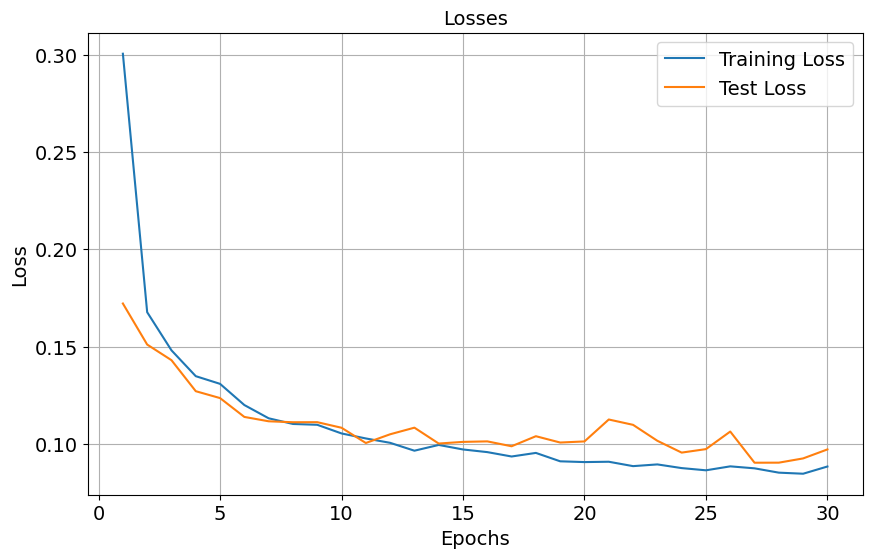

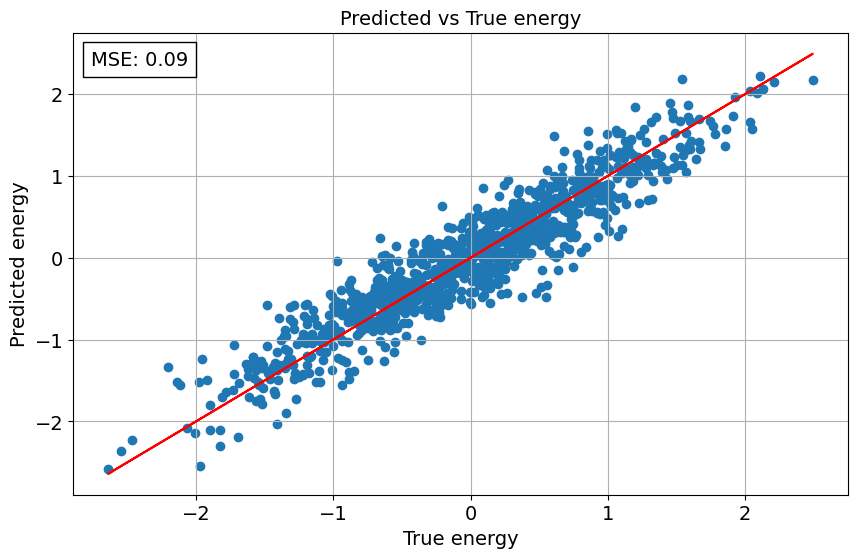

--------------------------------------------


n_dimensions: 1, periodic: True, number of connections: 10


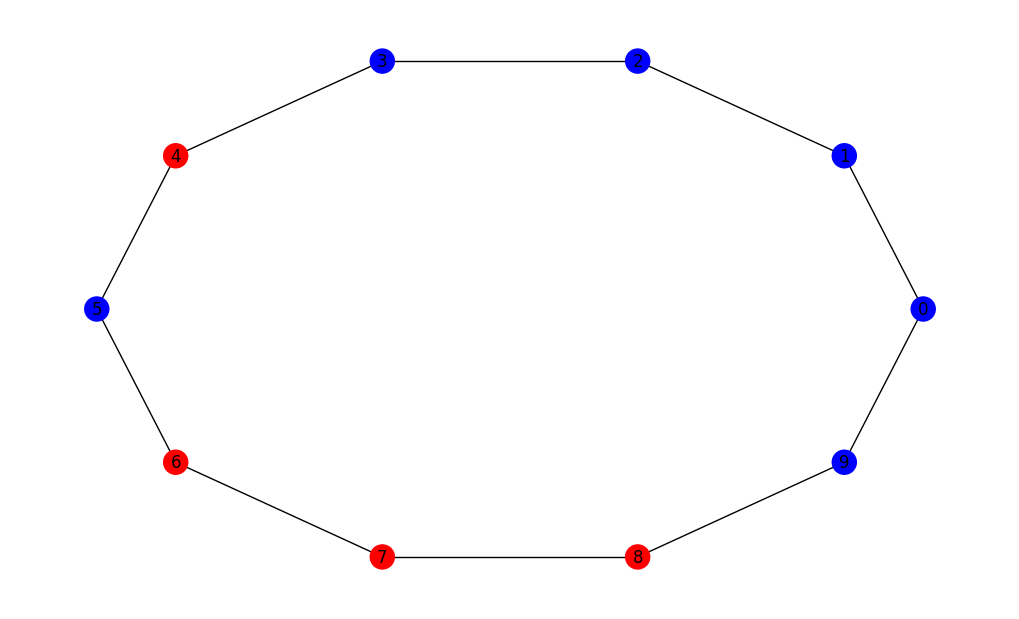

Training ...
Ep 1 	| Loss 0.36462 	| Test Loss 0.24992
Ep 2 	| Loss 0.20478 	| Test Loss 0.19214
Ep 3 	| Loss 0.18332 	| Test Loss 0.20413
Ep 4 	| Loss 0.1633 	| Test Loss 0.1801
Ep 5 	| Loss 0.14853 	| Test Loss 0.19934
Ep 6 	| Loss 0.14569 	| Test Loss 0.1449
Ep 7 	| Loss 0.14351 	| Test Loss 0.16416
Ep 8 	| Loss 0.13688 	| Test Loss 0.15271
Ep 9 	| Loss 0.13235 	| Test Loss 0.15319
Ep 10 	| Loss 0.12773 	| Test Loss 0.12238
Ep 11 	| Loss 0.12655 	| Test Loss 0.13652
Ep 12 	| Loss 0.12198 	| Test Loss 0.13328
Ep 13 	| Loss 0.12044 	| Test Loss 0.13081
Ep 14 	| Loss 0.1157 	| Test Loss 0.12864
Ep 15 	| Loss 0.11754 	| Test Loss 0.12444
Ep 16 	| Loss 0.11269 	| Test Loss 0.12638
Ep 17 	| Loss 0.11353 	| Test Loss 0.11973
Ep 18 	| Loss 0.11138 	| Test Loss 0.12295
Ep 19 	| Loss 0.11465 	| Test Loss 0.12161
Ep 20 	| Loss 0.10669 	| Test Loss 0.11956
Ep 21 	| Loss 0.1074 	| Test Loss 0.11599
Ep 22 	| Loss 0.10959 	| Test Loss 0.12107
Ep 23 	| Loss 0.10438 	| Test Loss 0.11418
Ep 24 	| Los

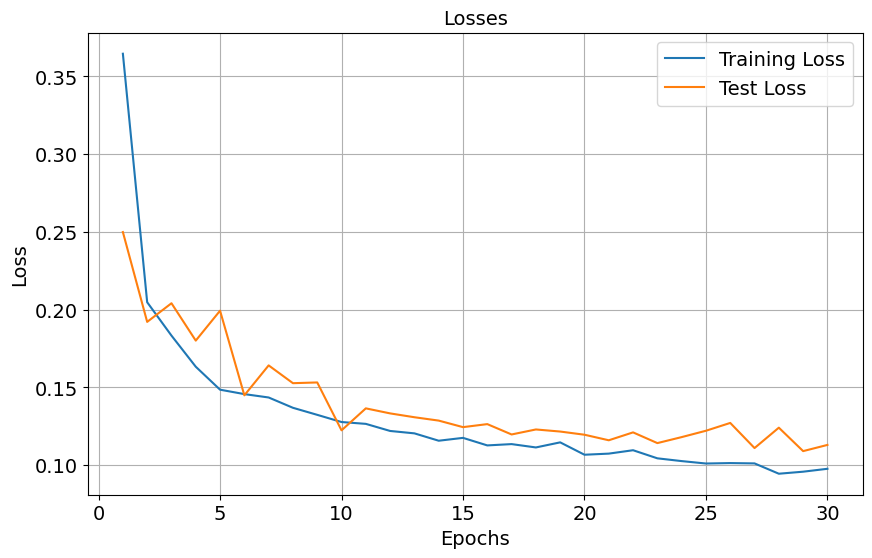

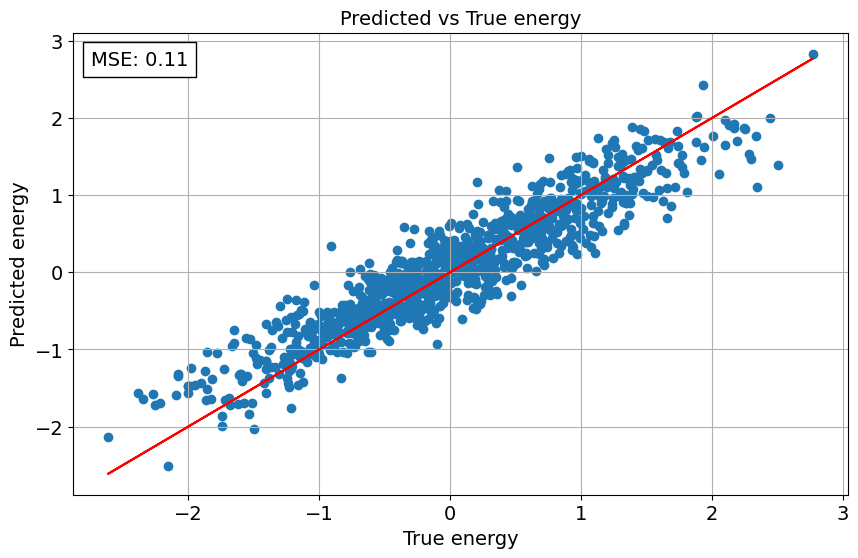

--------------------------------------------


n_dimensions: 2, periodic: False, number of connections: 17


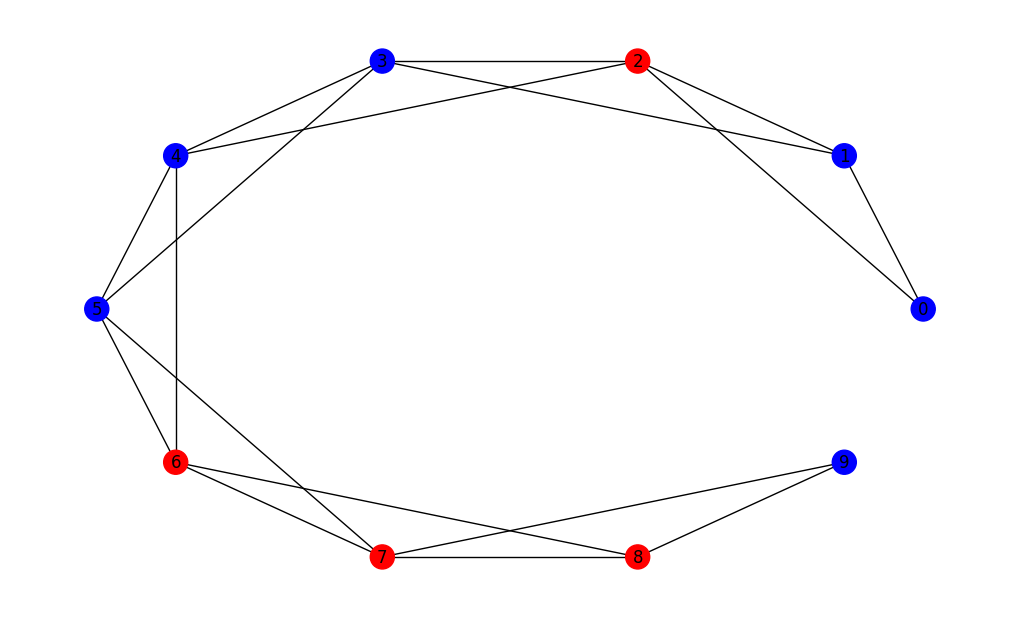

Training ...
Ep 1 	| Loss 0.59929 	| Test Loss 0.37898
Ep 2 	| Loss 0.33305 	| Test Loss 0.33323
Ep 3 	| Loss 0.29703 	| Test Loss 0.28993
Ep 4 	| Loss 0.27685 	| Test Loss 0.27394
Ep 5 	| Loss 0.25529 	| Test Loss 0.25548
Ep 6 	| Loss 0.25311 	| Test Loss 0.23609
Ep 7 	| Loss 0.23485 	| Test Loss 0.25786
Ep 8 	| Loss 0.23567 	| Test Loss 0.24424
Ep 9 	| Loss 0.21696 	| Test Loss 0.25983
Ep 10 	| Loss 0.2114 	| Test Loss 0.2502
Ep 11 	| Loss 0.20679 	| Test Loss 0.26825
Ep 12 	| Loss 0.20379 	| Test Loss 0.24744
Ep 13 	| Loss 0.19713 	| Test Loss 0.22734
Ep 14 	| Loss 0.18831 	| Test Loss 0.21647
Ep 15 	| Loss 0.18975 	| Test Loss 0.21591
Ep 16 	| Loss 0.18417 	| Test Loss 0.21135
Ep 17 	| Loss 0.18217 	| Test Loss 0.21785
Ep 18 	| Loss 0.17665 	| Test Loss 0.21853
Ep 19 	| Loss 0.17981 	| Test Loss 0.21548
Ep 20 	| Loss 0.17468 	| Test Loss 0.28181
Ep 21 	| Loss 0.16811 	| Test Loss 0.21037
Ep 22 	| Loss 0.17556 	| Test Loss 0.20881
Ep 23 	| Loss 0.16947 	| Test Loss 0.20035
Ep 24 	| 

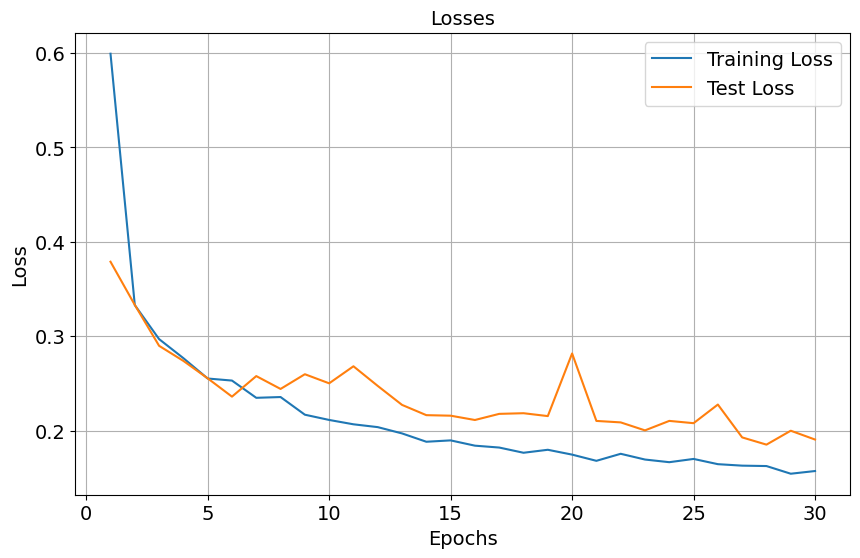

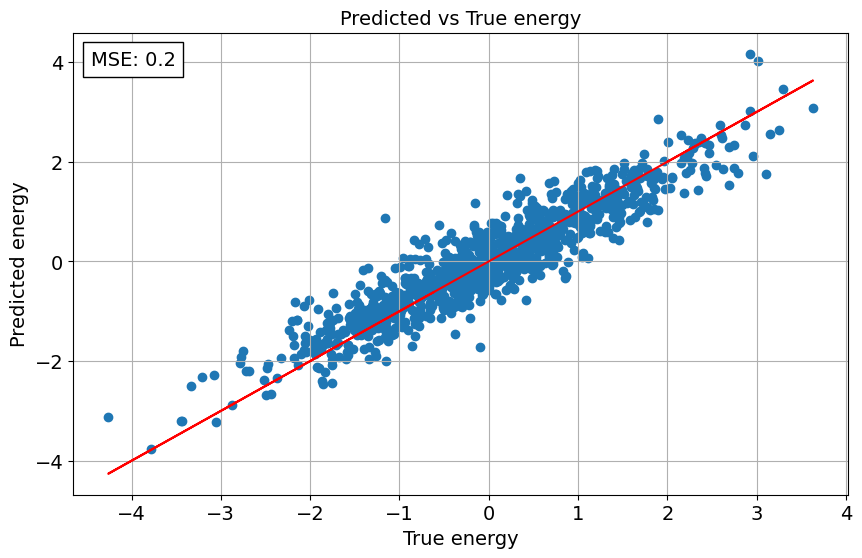

--------------------------------------------


n_dimensions: 2, periodic: True, number of connections: 20


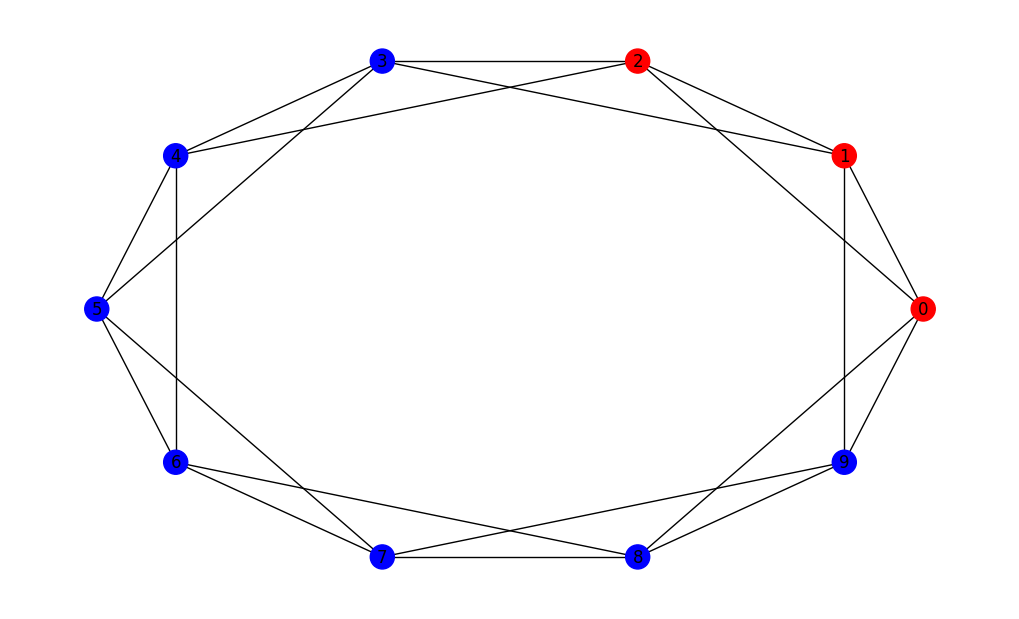

Training ...
Ep 1 	| Loss 0.7221 	| Test Loss 0.46347
Ep 2 	| Loss 0.42673 	| Test Loss 0.33251
Ep 3 	| Loss 0.35474 	| Test Loss 0.3115
Ep 4 	| Loss 0.33623 	| Test Loss 0.31516
Ep 5 	| Loss 0.31177 	| Test Loss 0.29758
Ep 6 	| Loss 0.28559 	| Test Loss 0.32517
Ep 7 	| Loss 0.28295 	| Test Loss 0.28069
Ep 8 	| Loss 0.27697 	| Test Loss 0.2807
Ep 9 	| Loss 0.26103 	| Test Loss 0.29568
Ep 10 	| Loss 0.24735 	| Test Loss 0.27571
Ep 11 	| Loss 0.25809 	| Test Loss 0.26349
Ep 12 	| Loss 0.23781 	| Test Loss 0.25191
Ep 13 	| Loss 0.23967 	| Test Loss 0.27875
Ep 14 	| Loss 0.23313 	| Test Loss 0.25848
Ep 15 	| Loss 0.23159 	| Test Loss 0.2796
Ep 16 	| Loss 0.21745 	| Test Loss 0.25358
Ep 17 	| Loss 0.22833 	| Test Loss 0.28658
Ep 18 	| Loss 0.22611 	| Test Loss 0.28099
Ep 19 	| Loss 0.21856 	| Test Loss 0.26547
Ep 20 	| Loss 0.21426 	| Test Loss 0.25448
Ep 21 	| Loss 0.20921 	| Test Loss 0.24706
Ep 22 	| Loss 0.20717 	| Test Loss 0.25969
Ep 23 	| Loss 0.20696 	| Test Loss 0.2498
Ep 24 	| Los

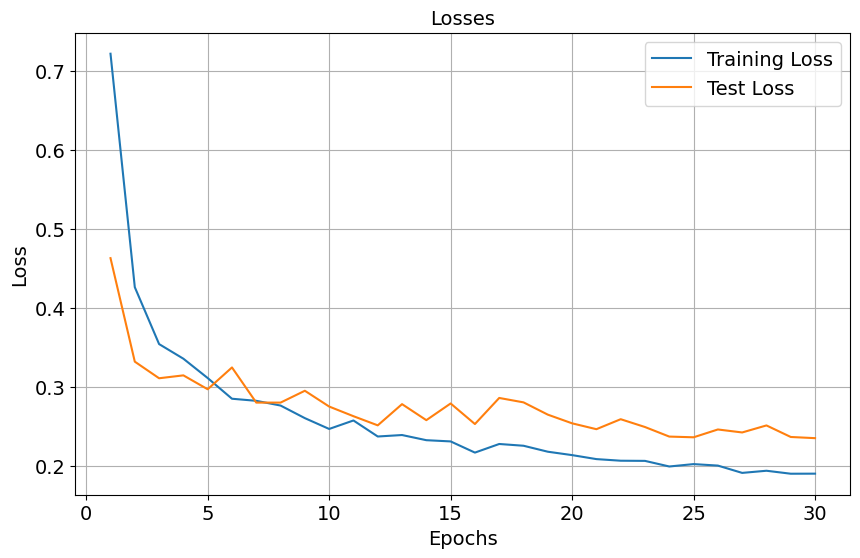

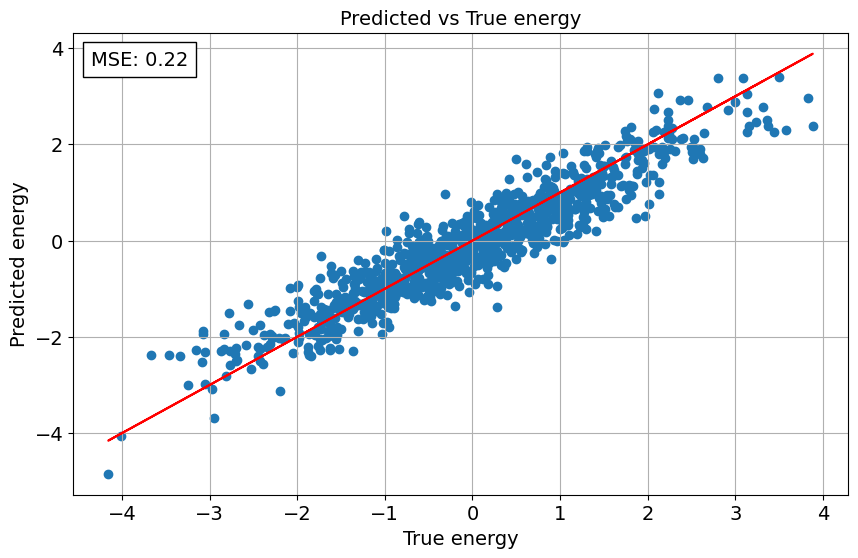

--------------------------------------------


n_dimensions: 3, periodic: False, number of connections: 24


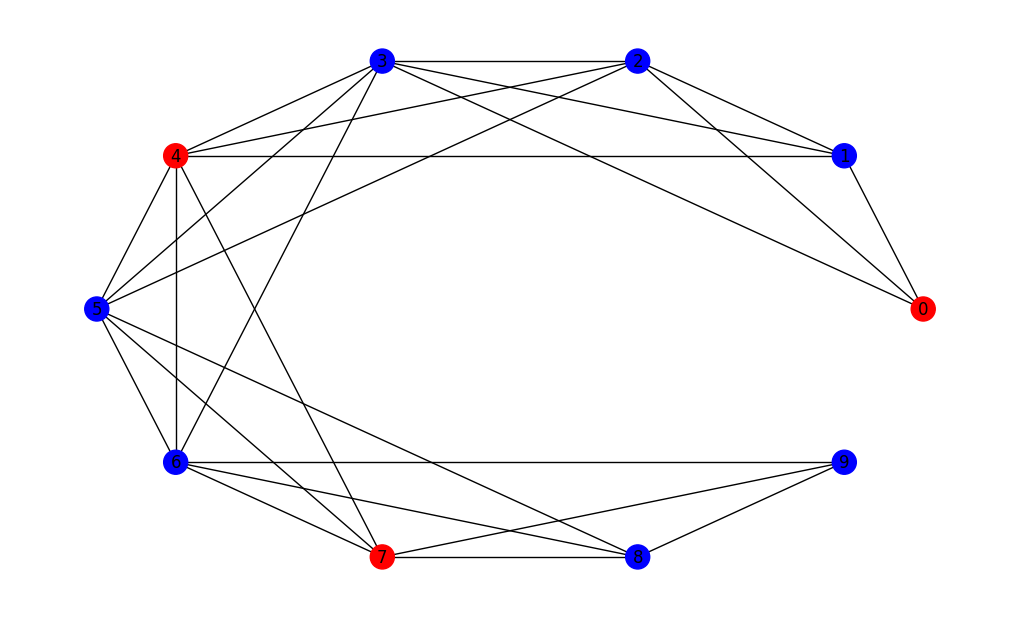

Training ...
Ep 1 	| Loss 0.90206 	| Test Loss 0.47568
Ep 2 	| Loss 0.46506 	| Test Loss 0.41649
Ep 3 	| Loss 0.41116 	| Test Loss 0.37434
Ep 4 	| Loss 0.37054 	| Test Loss 0.31822
Ep 5 	| Loss 0.34021 	| Test Loss 0.30246
Ep 6 	| Loss 0.33376 	| Test Loss 0.31118
Ep 7 	| Loss 0.30161 	| Test Loss 0.30558
Ep 8 	| Loss 0.30391 	| Test Loss 0.32425
Ep 9 	| Loss 0.29248 	| Test Loss 0.28395
Ep 10 	| Loss 0.27679 	| Test Loss 0.29492
Ep 11 	| Loss 0.27185 	| Test Loss 0.26376
Ep 12 	| Loss 0.26893 	| Test Loss 0.26432
Ep 13 	| Loss 0.26521 	| Test Loss 0.28503
Ep 14 	| Loss 0.25219 	| Test Loss 0.28516
Ep 15 	| Loss 0.25496 	| Test Loss 0.31681
Ep 16 	| Loss 0.24152 	| Test Loss 0.2588
Ep 17 	| Loss 0.24208 	| Test Loss 0.26637
Ep 18 	| Loss 0.23298 	| Test Loss 0.2463
Ep 19 	| Loss 0.24041 	| Test Loss 0.25412
Ep 20 	| Loss 0.23302 	| Test Loss 0.24436
Ep 21 	| Loss 0.21885 	| Test Loss 0.28496
Ep 22 	| Loss 0.22341 	| Test Loss 0.25513
Ep 23 	| Loss 0.22052 	| Test Loss 0.25398
Ep 24 	| 

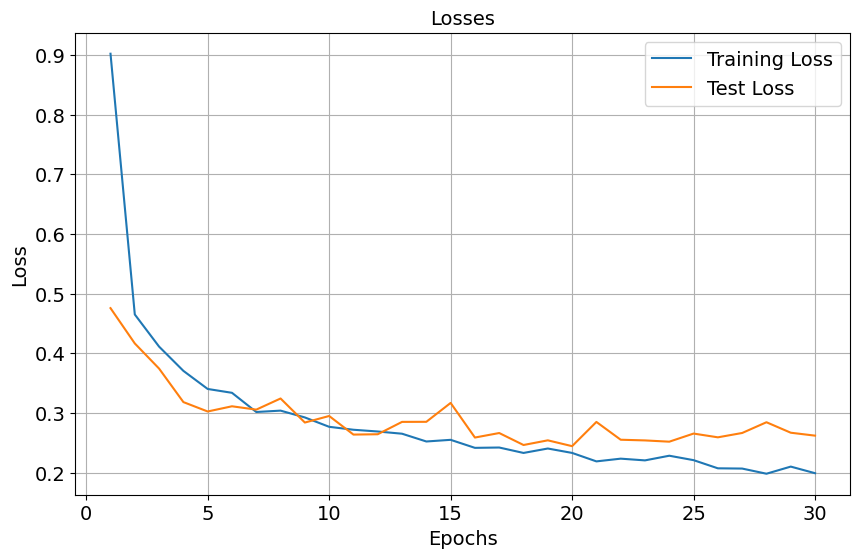

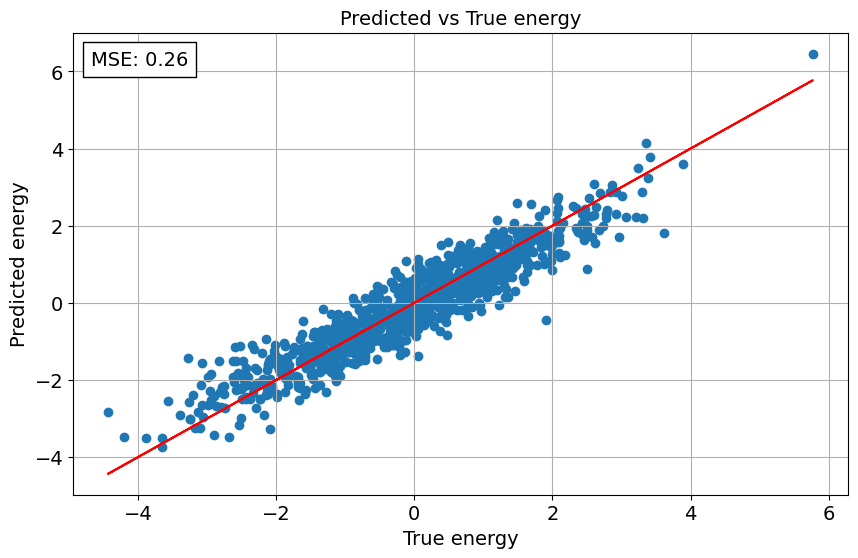

--------------------------------------------


n_dimensions: 3, periodic: True, number of connections: 30


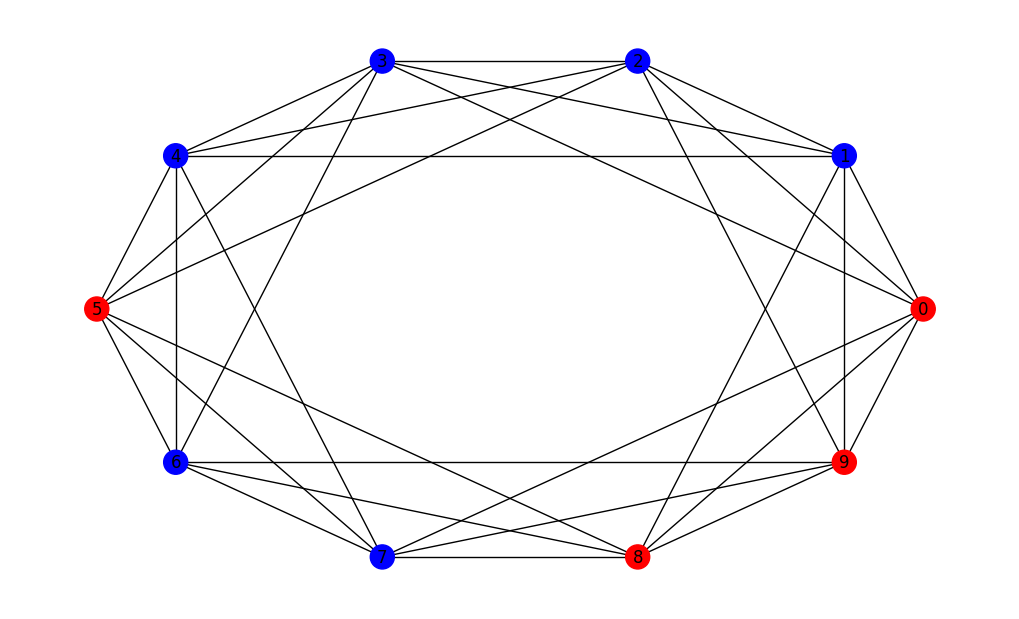

Training ...
Ep 1 	| Loss 1.07362 	| Test Loss 0.60945
Ep 2 	| Loss 0.55675 	| Test Loss 0.51542
Ep 3 	| Loss 0.49609 	| Test Loss 0.53475
Ep 4 	| Loss 0.44428 	| Test Loss 0.45321
Ep 5 	| Loss 0.40345 	| Test Loss 0.52091
Ep 6 	| Loss 0.42096 	| Test Loss 0.43184
Ep 7 	| Loss 0.37677 	| Test Loss 0.57242
Ep 8 	| Loss 0.3604 	| Test Loss 0.47685
Ep 9 	| Loss 0.35536 	| Test Loss 0.50529
Ep 10 	| Loss 0.33982 	| Test Loss 0.44782
Ep 11 	| Loss 0.32615 	| Test Loss 0.42208
Ep 12 	| Loss 0.32487 	| Test Loss 0.42639
Ep 13 	| Loss 0.31562 	| Test Loss 0.46987
Ep 14 	| Loss 0.31487 	| Test Loss 0.39838
Ep 15 	| Loss 0.29978 	| Test Loss 0.35976
Ep 16 	| Loss 0.30205 	| Test Loss 0.38199
Ep 17 	| Loss 0.29135 	| Test Loss 0.37131
Ep 18 	| Loss 0.28262 	| Test Loss 0.43321
Ep 19 	| Loss 0.28107 	| Test Loss 0.39929
Ep 20 	| Loss 0.26356 	| Test Loss 0.41516
Ep 21 	| Loss 0.27369 	| Test Loss 0.39406
Ep 22 	| Loss 0.26652 	| Test Loss 0.37541
Ep 23 	| Loss 0.25195 	| Test Loss 0.3631
Ep 24 	| 

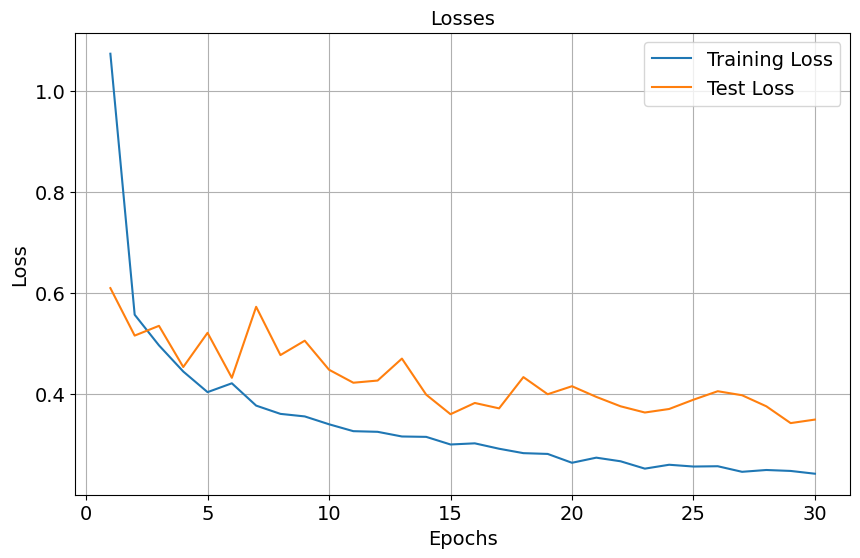

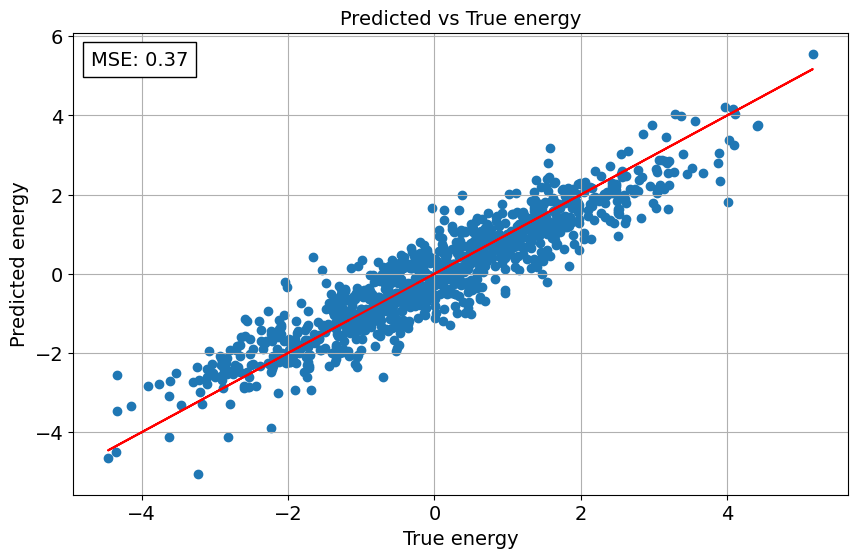

--------------------------------------------


n_dimensions: 4, periodic: False, number of connections: 30


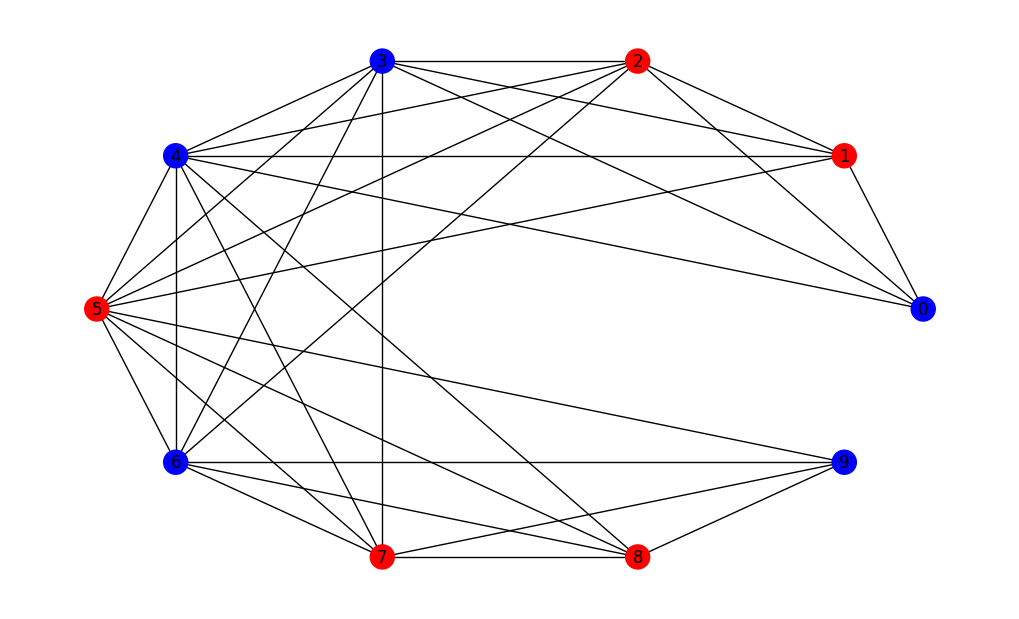

Training ...
Ep 1 	| Loss 1.17675 	| Test Loss 0.62764
Ep 2 	| Loss 0.56552 	| Test Loss 0.54696
Ep 3 	| Loss 0.49261 	| Test Loss 0.45481
Ep 4 	| Loss 0.44679 	| Test Loss 0.46041
Ep 5 	| Loss 0.4138 	| Test Loss 0.39369
Ep 6 	| Loss 0.40053 	| Test Loss 0.38994
Ep 7 	| Loss 0.36612 	| Test Loss 0.36484
Ep 8 	| Loss 0.34881 	| Test Loss 0.35059
Ep 9 	| Loss 0.32275 	| Test Loss 0.35564
Ep 10 	| Loss 0.33599 	| Test Loss 0.34674
Ep 11 	| Loss 0.31641 	| Test Loss 0.35193
Ep 12 	| Loss 0.30554 	| Test Loss 0.32901
Ep 13 	| Loss 0.30685 	| Test Loss 0.35677
Ep 14 	| Loss 0.29032 	| Test Loss 0.34776
Ep 15 	| Loss 0.27797 	| Test Loss 0.30471
Ep 16 	| Loss 0.28115 	| Test Loss 0.35316
Ep 17 	| Loss 0.26738 	| Test Loss 0.34047
Ep 18 	| Loss 0.2801 	| Test Loss 0.31734
Ep 19 	| Loss 0.26404 	| Test Loss 0.33655
Ep 20 	| Loss 0.25676 	| Test Loss 0.30784
Ep 21 	| Loss 0.24189 	| Test Loss 0.32166
Ep 22 	| Loss 0.25029 	| Test Loss 0.3304
Ep 23 	| Loss 0.24299 	| Test Loss 0.33983
Ep 24 	| L

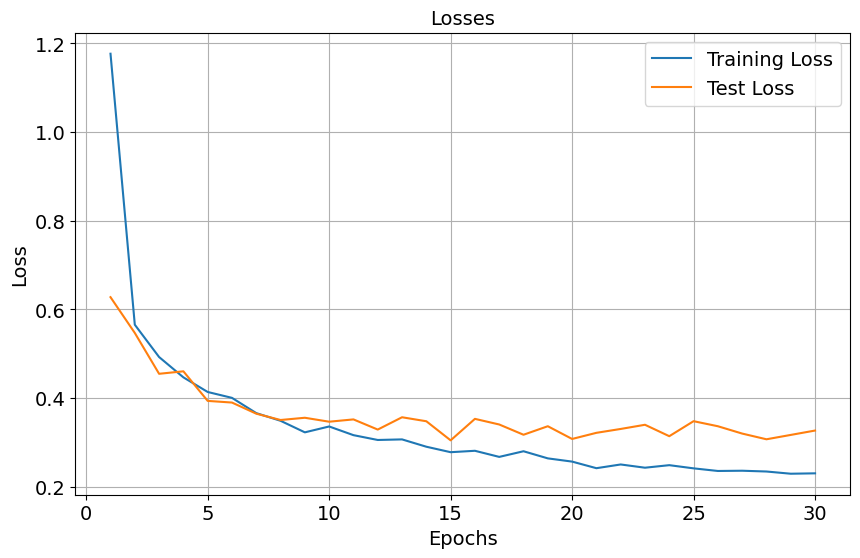

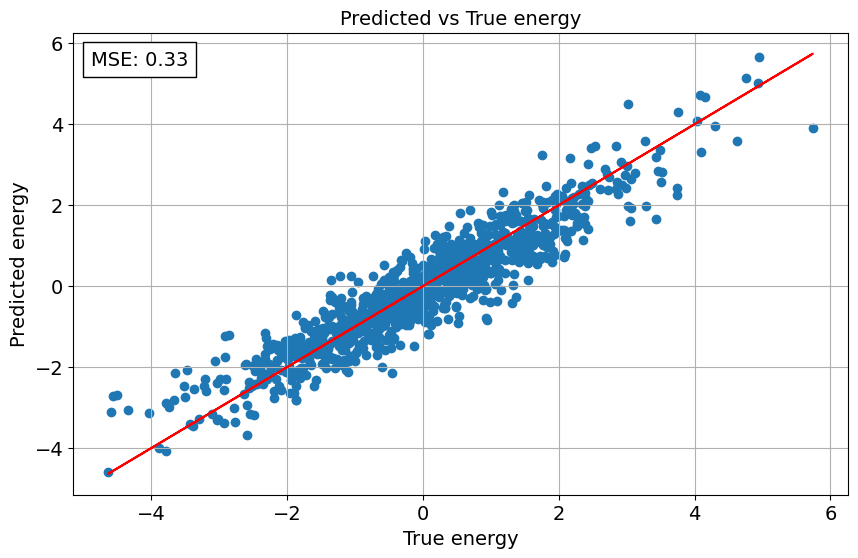

--------------------------------------------


n_dimensions: 4, periodic: True, number of connections: 40


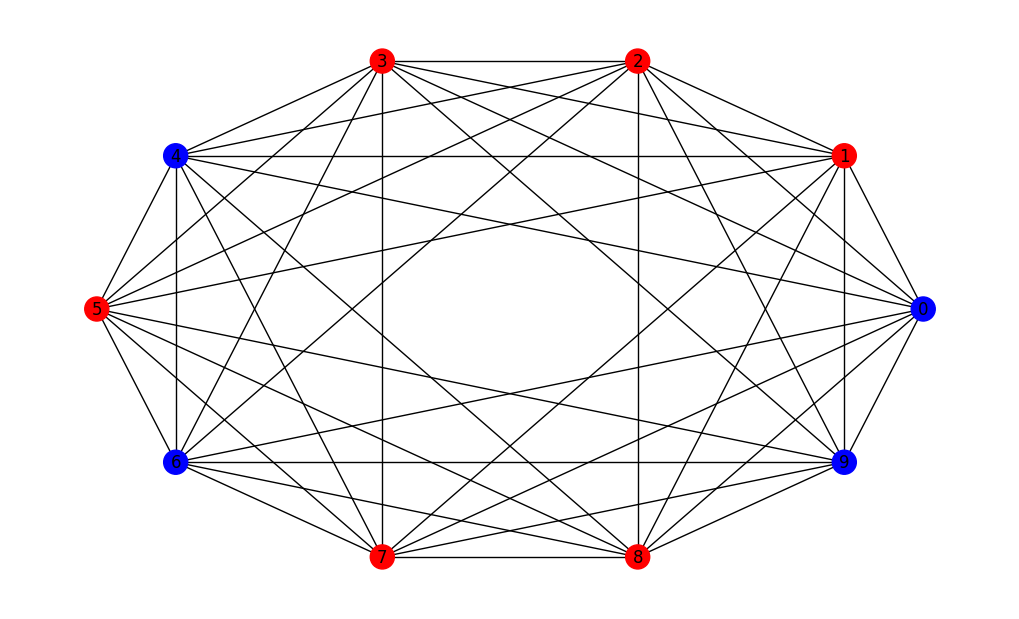

Training ...
Ep 1 	| Loss 1.64766 	| Test Loss 0.77775
Ep 2 	| Loss 0.77253 	| Test Loss 0.66355
Ep 3 	| Loss 0.6857 	| Test Loss 0.64755
Ep 4 	| Loss 0.62302 	| Test Loss 0.607
Ep 5 	| Loss 0.58356 	| Test Loss 0.55496
Ep 6 	| Loss 0.55453 	| Test Loss 0.61645
Ep 7 	| Loss 0.51029 	| Test Loss 0.51907
Ep 8 	| Loss 0.50529 	| Test Loss 0.56228
Ep 9 	| Loss 0.46926 	| Test Loss 0.50558
Ep 10 	| Loss 0.45214 	| Test Loss 0.50732
Ep 11 	| Loss 0.43214 	| Test Loss 0.49698
Ep 12 	| Loss 0.42502 	| Test Loss 0.45938
Ep 13 	| Loss 0.41235 	| Test Loss 0.48503
Ep 14 	| Loss 0.42571 	| Test Loss 0.42177
Ep 15 	| Loss 0.40556 	| Test Loss 0.48418
Ep 16 	| Loss 0.3923 	| Test Loss 0.49509
Ep 17 	| Loss 0.37776 	| Test Loss 0.48151
Ep 18 	| Loss 0.38811 	| Test Loss 0.56591
Ep 19 	| Loss 0.38405 	| Test Loss 0.48422
Ep 20 	| Loss 0.36262 	| Test Loss 0.46165
Ep 21 	| Loss 0.34908 	| Test Loss 0.47033
Ep 22 	| Loss 0.36972 	| Test Loss 0.4809
Ep 23 	| Loss 0.35366 	| Test Loss 0.46746
Ep 24 	| Los

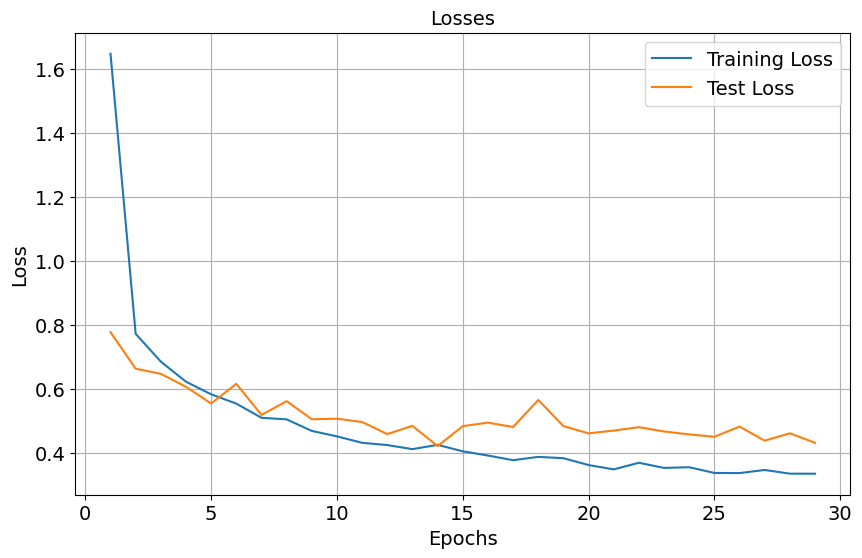

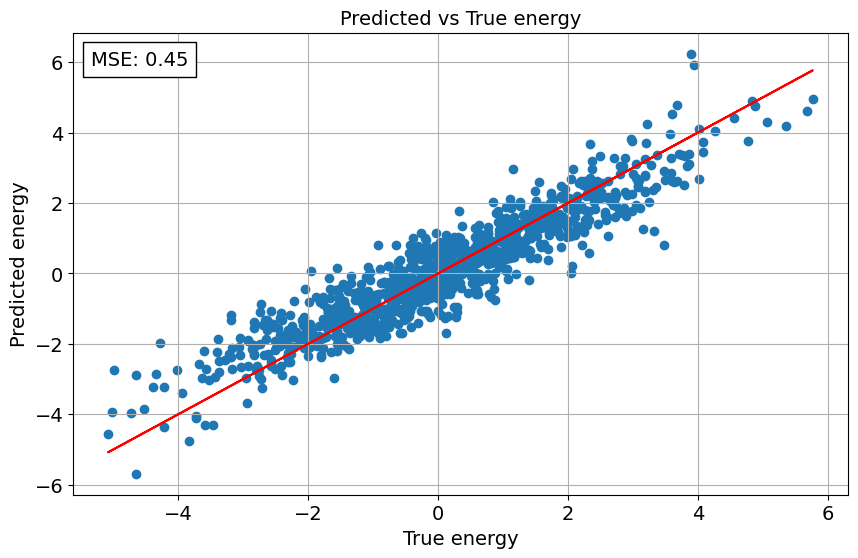

--------------------------------------------


n_dimensions: 5, periodic: False, number of connections: 35


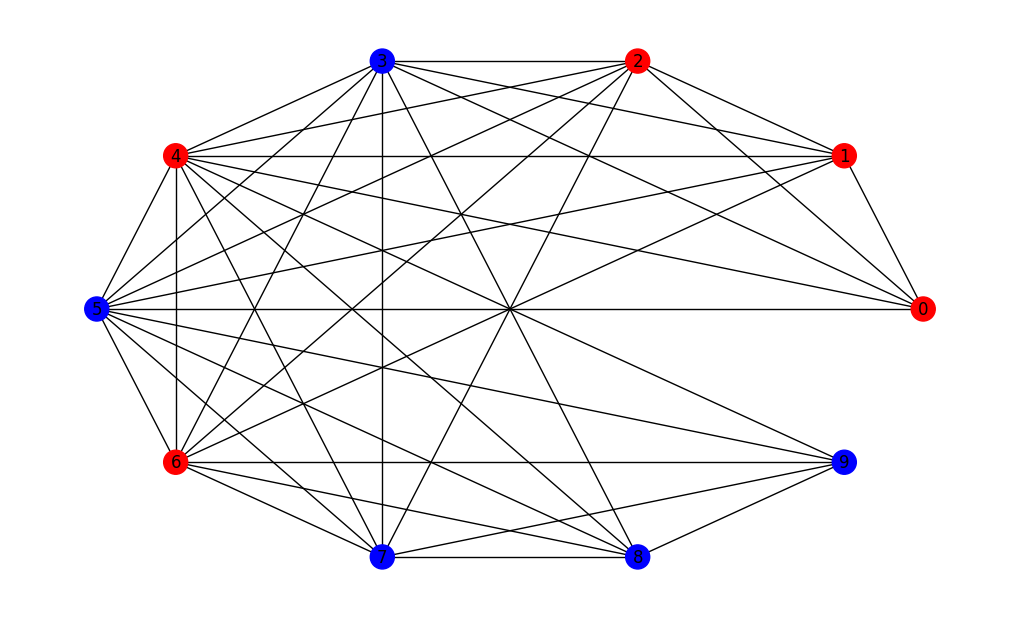

Training ...
Ep 1 	| Loss 1.43343 	| Test Loss 0.69214
Ep 2 	| Loss 0.66286 	| Test Loss 0.61333
Ep 3 	| Loss 0.58603 	| Test Loss 0.59359
Ep 4 	| Loss 0.5241 	| Test Loss 0.55686
Ep 5 	| Loss 0.50106 	| Test Loss 0.51529
Ep 6 	| Loss 0.46548 	| Test Loss 0.50312
Ep 7 	| Loss 0.4343 	| Test Loss 0.49097
Ep 8 	| Loss 0.41448 	| Test Loss 0.44178
Ep 9 	| Loss 0.39961 	| Test Loss 0.46176
Ep 10 	| Loss 0.39871 	| Test Loss 0.44101
Ep 11 	| Loss 0.38548 	| Test Loss 0.52979
Ep 12 	| Loss 0.37672 	| Test Loss 0.51028
Ep 13 	| Loss 0.3551 	| Test Loss 0.46
Ep 14 	| Loss 0.34889 	| Test Loss 0.43012
Ep 15 	| Loss 0.35261 	| Test Loss 0.41082
Ep 16 	| Loss 0.35299 	| Test Loss 0.47522
Ep 17 	| Loss 0.32906 	| Test Loss 0.50816
Ep 18 	| Loss 0.33343 	| Test Loss 0.46008
Ep 19 	| Loss 0.32063 	| Test Loss 0.40959
Ep 20 	| Loss 0.31766 	| Test Loss 0.46392
Ep 21 	| Loss 0.31097 	| Test Loss 0.4377
Ep 22 	| Loss 0.30835 	| Test Loss 0.40041
Ep 23 	| Loss 0.29972 	| Test Loss 0.42575
Ep 24 	| Loss 

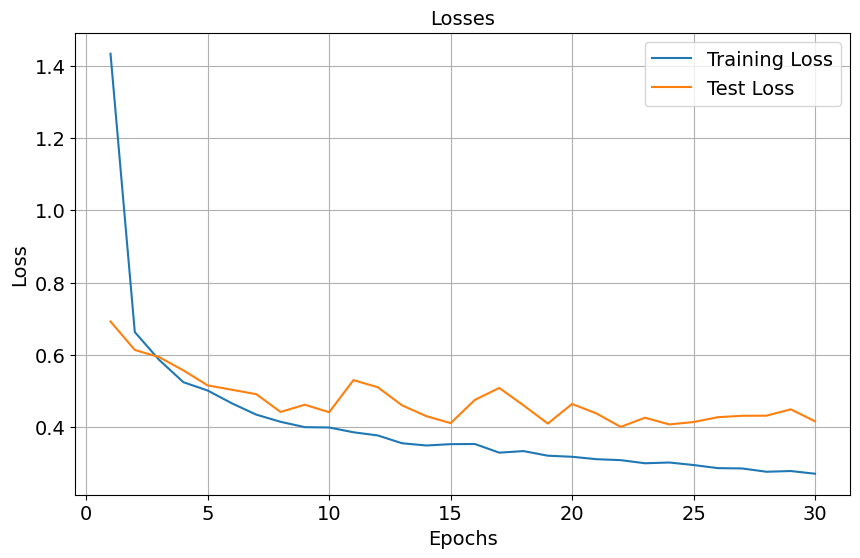

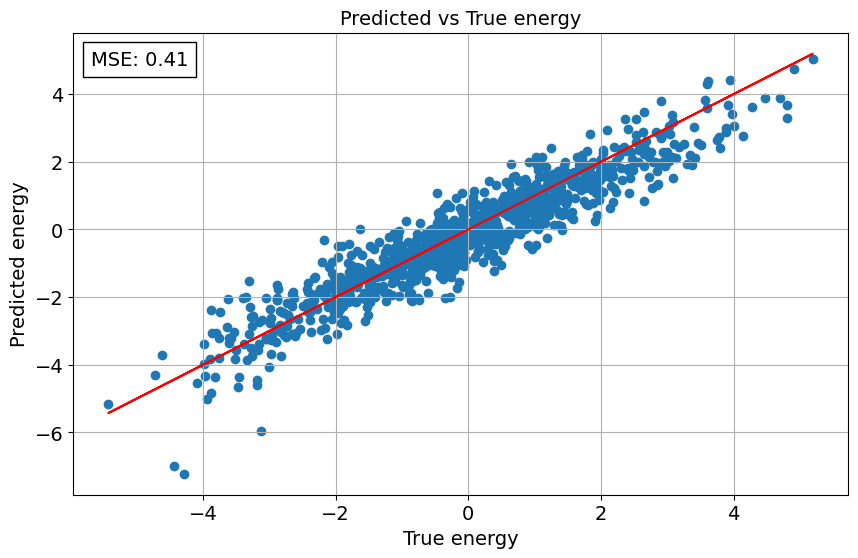

--------------------------------------------


n_dimensions: 5, periodic: True, number of connections: 45


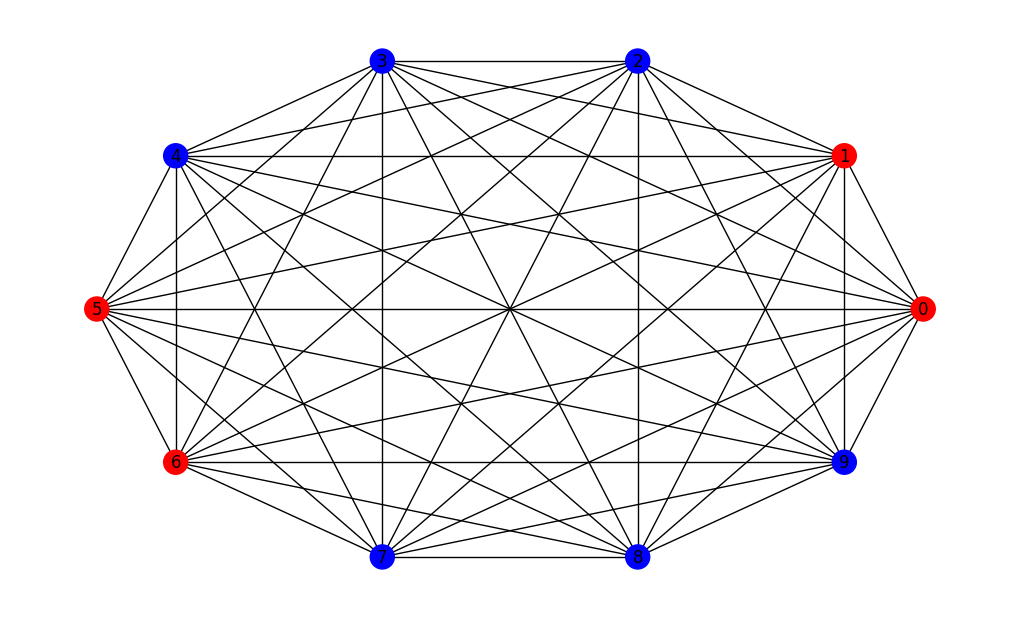

Training ...
Ep 1 	| Loss 1.806 	| Test Loss 0.91178
Ep 2 	| Loss 0.81287 	| Test Loss 0.87042
Ep 3 	| Loss 0.6943 	| Test Loss 0.8239
Ep 4 	| Loss 0.6439 	| Test Loss 0.74685
Ep 5 	| Loss 0.60787 	| Test Loss 0.64877
Ep 6 	| Loss 0.56746 	| Test Loss 0.65946
Ep 7 	| Loss 0.55346 	| Test Loss 0.63194
Ep 8 	| Loss 0.52909 	| Test Loss 0.70599
Ep 9 	| Loss 0.51273 	| Test Loss 0.68313
Ep 10 	| Loss 0.48768 	| Test Loss 0.64354
Ep 11 	| Loss 0.46766 	| Test Loss 0.65164
Ep 12 	| Loss 0.45765 	| Test Loss 0.65314
Ep 13 	| Loss 0.44732 	| Test Loss 0.58229
Ep 14 	| Loss 0.42442 	| Test Loss 0.60545
Ep 15 	| Loss 0.42749 	| Test Loss 0.58629
Ep 16 	| Loss 0.41077 	| Test Loss 0.61255
Ep 17 	| Loss 0.40411 	| Test Loss 0.61544
Ep 18 	| Loss 0.41446 	| Test Loss 0.59655
Ep 19 	| Loss 0.41255 	| Test Loss 0.61651
Ep 20 	| Loss 0.381 	| Test Loss 0.57119
Ep 21 	| Loss 0.39167 	| Test Loss 0.73566
Ep 22 	| Loss 0.37414 	| Test Loss 0.51945
Ep 23 	| Loss 0.37752 	| Test Loss 0.60802
Ep 24 	| Loss 

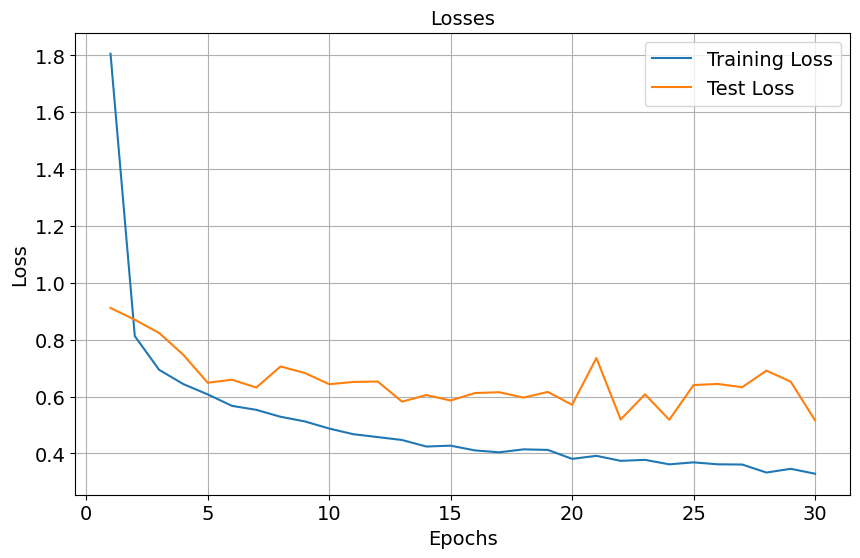

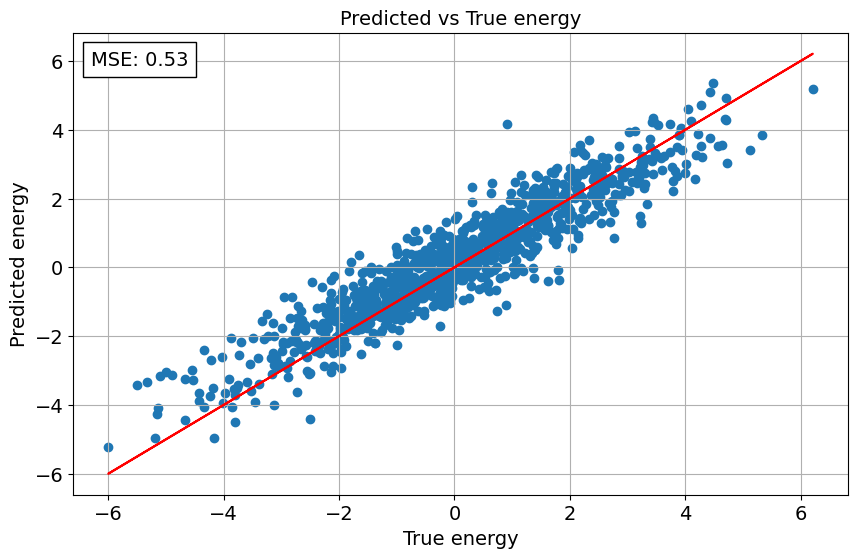

--------------------------------------------




In [24]:
i = 0 # index to keep track of the dataset

for n_dimensions in list_dimensions:
    for periodic in list_periodic:

        dataset = list_datasets[i]
        graphs = list_graphs[i]

        # get number of connections
        n_connections = len(graphs[0].edges)
        list_n_connections.append(n_connections)

        print(f"n_dimensions: {n_dimensions}, periodic: {periodic}, number of connections: {n_connections}")

        # plot the first graph
        fig = plot_graph(graphs[0])


        # split the dataset into training and test set and create the loaders
        train_loader = DataLoader(dataset[:int(0.8*n_samples)], batch_size=batch_size, shuffle=False) # shuffle not needed
        test_loader = DataLoader(dataset[int(0.8*n_samples):], batch_size=batch_size, shuffle=False)

        # copy the model from scratch
        model = GNN(hidden_channels_1=hidden_channels_1, hidden_channels_2=hidden_channels_2, hidden_channels_3=hidden_channels_3,
            hidden_channels_4=hidden_channels_4, hidden_linear=hidden_linear, lr=lr, weight_decay=weight_decay, dropout=dropout)

        model.to(device)

        # set the model name
        model_name = set_model_name(n_nodes, n_dimensions, h, periodic, n_samples, hidden_channels_1, hidden_channels_2, hidden_channels_3, hidden_channels_4, hidden_linear, lr, weight_decay, dropout,num_epochs)
        list_model_names.append(model_name)

        try:
            os.mkdir(model_name)
        except:
            pass

        # save the graph plot 
        fig.savefig(model_name + "/graph.png")

        # train the model
        train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, patience=patience, model_name=model_name, verbose=True, device=device)
        list_train_losses.append(train_losses)
        list_test_losses.append(test_losses)

        # save train and test losses 
        np.save(model_name + '/train_losses.npy', train_losses)
        np.save(model_name + '/test_losses.npy', test_losses)
          

        # plot the losses
        fig_losses = plot_loss(train_losses, test_losses)
        fig_losses.savefig(model_name + "/losses.png")
        list_fig_losses.append(fig_losses)

        # test the trained model
        fig, mse = test_trained_model(model_name, test_loader, device=device)
        fig.savefig(model_name + "/test.png")
        list_fig_tests.append(fig)

        # store the mse
        list_mse.append(mse)

        print(44 * '-')
        print("\n")

        folder_name = f"n_nodes_{n_nodes}_n_dimensions_{n_dimensions}"
        try: os.mkdir(folder_name)
        except: pass

        # move the files to the folder
        os.system(f"mv {model_name} {folder_name}/{model_name}")     

        i += 1 # update the index for the dataset
                     

        

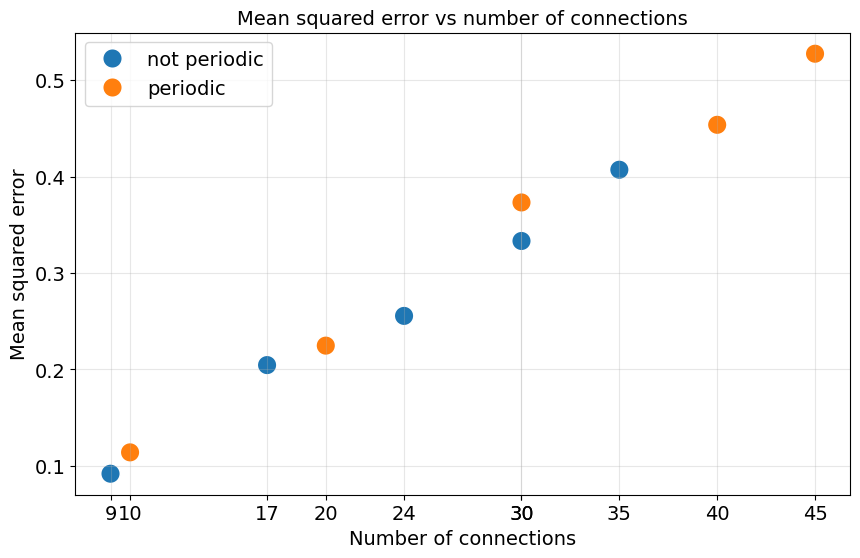

In [56]:
# plot the mse vs the number of connections
fig = plt.figure()
# set a label for even positions on list_n_connections
labels = ["not periodic" if i%2 == 0 else "periodic" for i in np.arange(len(list_n_connections))]


sns.scatterplot(x = list_n_connections, y= list_mse, hue=labels, size=labels, sizes=(200, 200) )

plt.xlabel('Number of connections')
plt.ylabel('Mean squared error')
plt.title('Mean squared error vs number of connections')
plt.xticks(list_n_connections)
plt.grid(alpha=0.3)


plt.show(fig)
fig.savefig(f"mse_vs_connections_{n_samples}.png")


In [67]:

# move everything to a new folder called n_nodes_10
try: os.mkdir("n_nodes_10")
except: pass

for dim in list_dimensions:
    os.system(f"mv n_nodes_10_n_dimensions_{dim}/* n_nodes_10/n_nodes_10_n_dimensions_{dim}/")
    os.system(f"rm -r n_nodes_10_n_dimensions_{dim}")
#os.system("mv datasets n_nodes_10")

os.system(f"mv mse_vs_connections_{n_samples}.png n_nodes_10")



mv: impossibile eseguire stat di 'n_nodes_10_n_dimensions_1/*': File o directory non esistente
mv: impossibile eseguire stat di 'n_nodes_10_n_dimensions_2/*': File o directory non esistente
rm: impossibile rimuovere 'n_nodes_10_n_dimensions_2': File o directory non esistente
mv: impossibile eseguire stat di 'n_nodes_10_n_dimensions_3/*': File o directory non esistente
rm: impossibile rimuovere 'n_nodes_10_n_dimensions_3': File o directory non esistente
mv: impossibile eseguire stat di 'n_nodes_10_n_dimensions_4/*': File o directory non esistente
rm: impossibile rimuovere 'n_nodes_10_n_dimensions_4': File o directory non esistente
mv: impossibile eseguire stat di 'n_nodes_10_n_dimensions_5/*': File o directory non esistente
rm: impossibile rimuovere 'n_nodes_10_n_dimensions_5': File o directory non esistente
mv: impossibile eseguire stat di 'mse_vs_connections_5000.png': File o directory non esistente


256